#Importing Packages

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split

In [ ]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 4.3MB/s 


In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

## Downloading Dataset


ChestX-ray dataset comprises 112,120 frontal-view X-ray images of 30,805 unique patients with the text-mined fourteen disease image labels (where each image can have multi-labels), mined from the associated radiological reports using natural language processing. 
Fourteen common thoracic pathologies include: 


1. Atelectasis
2. Consolidation
3. Infiltration
4. Pneumothorax
5. Edema
6. Emphysema
7. Fibrosis
8. Effusion
9. Pneumonia
10. Pleural_thickening
11. Cardiomegaly
12. Nodule
13. Mass
14. Hernia

These in turn can be used by physicians to diagnose 8 different diseases.
[The dataset can be found here](https://nihcc.app.box.com/v/ChestXray-NIHCC)

In [ ]:
# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

targz_files = list()

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    targz_files.append(fn)
    print('downloading '+fn+'...')
    urllib.request.urlretrieve(link, fn)  # download the zip file

print("Download complete. Please check the checksums")

downloadingimages_01.tar.gz...
downloadingimages_02.tar.gz...
downloadingimages_03.tar.gz...
downloadingimages_04.tar.gz...
downloadingimages_05.tar.gz...
downloadingimages_06.tar.gz...
downloadingimages_07.tar.gz...
downloadingimages_08.tar.gz...
downloadingimages_09.tar.gz...
downloadingimages_10.tar.gz...
downloadingimages_11.tar.gz...
downloadingimages_12.tar.gz...
Download complete. Please check the checksums


Images in the ChestX-ray dataset are divided into these two sets on the patient level. All studies from the same patient will only appear in either training/validation or testing set. 

In [ ]:
for idx, filename in enumerate(targz_files):
  shutil.unpack_archive(filename, "images")

The website for this dataset also contains 3 files that we'll be using.


1.   Data_Entry_2017_v2020.csv (containts patient information and labels of each image)
2.  train_val_list.txt
3. test_list.txt

The train_val_list.txt and test_list.txt files contain image IDs for trian and test sets and are already divided by patient IDs to prevent data leakage or patient overlap.

You should download these three files.



# Preprocessing data labels

In [5]:
datainfo = pd.read_csv("Data_Entry_2017_v2020.csv") 
datainfo.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [6]:
datainfo.shape

(112120, 11)

In [7]:
classes = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [8]:
labels = datainfo[['Image Index','Finding Labels', 'Patient ID']]
labels['Finding Labels'] = labels.loc[:,'Finding Labels'].str.split('|')
labels.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Image Index,Finding Labels,Patient ID
0,00000001_000.png,[Cardiomegaly],1
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1
2,00000001_002.png,"[Cardiomegaly, Effusion]",1
3,00000002_000.png,[No Finding],2
4,00000003_001.png,[Hernia],3


In [ ]:
labels['No finding'] = labels.loc[:,"Finding Labels"].str.contains("No Finding", regex=False)
labels['Cardiomegaly'] = labels.loc[:,"Finding Labels"].str.contains("Cardiomegaly", regex=False)
labels['Effusion'] = labels.loc[:,"Finding Labels"].str.contains("Effusion", regex=False)
labels['Hernia'] = labels.loc[:,"Finding Labels"].str.contains("Hernia", regex=False)
labels['Emphysema'] = labels.loc[:,"Finding Labels"].str.contains("Emphysema", regex=False)
labels['Atelectasis'] = labels.loc[:,"Finding Labels"].str.contains("Atelectasis", regex=False)
labels['Infiltration'] = labels.loc[:,"Finding Labels"].str.contains("Infiltration", regex=False)
labels['Nodule'] = labels.loc[:,"Finding Labels"].str.contains("Nodule", regex=False)
labels['Pleural_Thickening'] = labels.loc[:,"Finding Labels"].str.contains("Pleural_Thickening", regex=False)
labels['Pneumothorax'] = labels.loc[:,"Finding Labels"].str.contains("Pneumothorax", regex=False)
labels['Mass'] = labels.loc[:,"Finding Labels"].str.contains("Mass", regex=False)
labels['Fibrosis'] = labels.loc[:,"Finding Labels"].str.contains("Fibrosis", regex=False)
labels['Consolidation'] = labels.loc[:,"Finding Labels"].str.contains("Consolidation", regex=False)
labels['Pneumonia'] = labels.loc[:,"Finding Labels"].str.contains("Pneumonia", regex=False)
labels['Edema'] = labels.loc[:,"Finding Labels"].str.contains("Edema", regex=False)

In [10]:
labels.head()

,Image Index,Finding Labels,Patient ID,No finding,Cardiomegaly,Effusion,Hernia,Emphysema,Atelectasis,Infiltration,Nodule,Pleural_Thickening,Pneumothorax,Mass,Fibrosis,Consolidation,Pneumonia,Edema
0,00000001_000.png,[Cardiomegaly],1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
2,00000001_002.png,"[Cardiomegaly, Effusion]",1,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
3,00000002_000.png,[No Finding],2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,00000003_001.png,[Hernia],3,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [11]:
labels.sort_values(by=['Image Index'], inplace=True)

Converting boolean values to integers as labels

In [12]:
labels = labels * 1

In [13]:
labels.head()

,Image Index,Finding Labels,Patient ID,No finding,Cardiomegaly,Effusion,Hernia,Emphysema,Atelectasis,Infiltration,Nodule,Pleural_Thickening,Pneumothorax,Mass,Fibrosis,Consolidation,Pneumonia,Edema
0,00000001_000.png,[Cardiomegaly],1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,"[Cardiomegaly, Effusion]",1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,[No Finding],2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,00000003_000.png,[Hernia],3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


# Loading train and test datasets

Our dataset contains multiple images for each patient. Hence there could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have to ensure that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.
The dataset provided is already split by patient ID for train and test sets. We will further have to split the train dataset into train and validation sets.

In [14]:
train_val_imgs = pd.read_csv("train_val_list.txt", names=['Image Index'] ,header=None)
train_val_imgs.sort_values(by=['Image Index'], inplace=True)

In [15]:
test_imgs = pd.read_csv("test_list.txt", names=['Image Index'] ,header=None)
test_imgs.sort_values(by=['Image Index'], inplace=True)

In [16]:
print('Shape of train and validation set: ', train_val_imgs.shape)
print('Shape of test set: ', test_imgs.shape)

Shape of train and validation set:  (86524, 1)
Shape of test set:  (25596, 1)


# Preventing Data Leakage

In [17]:
def leakage(df1, df2, patient_col):
  """
    Return True if any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
  """
  df1_unique = set(df1[patient_col].unique().tolist())
  df2_unique = set(df2[patient_col].unique().tolist())

  patients_common = df1_unique.intersection(df2_unique)

  #leakage contains true if there is patient overlap, otherwise false.
  leakage = len(patients_common) >= 1

  return leakage

In [18]:
train = pd.merge(train_val_imgs, labels, how='inner', on=['Image Index'])
test = pd.merge(test_imgs, labels, how='inner', on=['Image Index'])
print(train.shape)
print(test.shape)

(86524, 18)
(25596, 18)


In [19]:
leakage(train, test, 'Patient ID')

False

# Addressing Class Imbalance

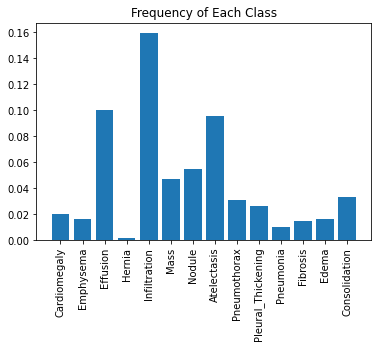

In [20]:
plt.xticks(rotation=90)
plt.bar(x=classes, height=np.mean(train[classes], axis=0))
plt.title("Frequency of Each Class")
plt.savefig('freqency_dist.png', bbox_inches='tight')
plt.show()
plt.close()

Computing class frequencies

In [21]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]   
    positive_frequencies = np.sum(labels, axis=0) / labels.shape[0]
    negative_frequencies = 1 - positive_frequencies
    
    return positive_frequencies, negative_frequencies

In [22]:
pos_freq, neg_freq = compute_class_freqs(train[classes])
pos_freq

Cardiomegaly          0.019729
Emphysema             0.016446
Effusion              0.100076
Hernia                0.001630
Infiltration          0.159285
Mass                  0.046623
Nodule                0.054413
Atelectasis           0.095696
Pneumothorax          0.030477
Pleural_Thickening    0.025912
Pneumonia             0.010124
Fibrosis              0.014458
Edema                 0.015926
Consolidation         0.032962
dtype: float64

Visualizing ratios of classes

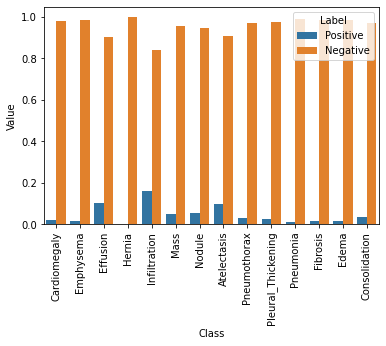

In [23]:
ratios = pd.DataFrame({"Class": classes, "Label": "Positive", "Value": pos_freq})
ratios = ratios.append([{"Class": classes[l], "Label": "Negative", "Value": v} for l,v in enumerate(neg_freq)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=ratios)

By multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, we can have the overall contribution of each class the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [24]:
pos_weights = neg_freq
neg_weights = pos_freq
pos_contribution = pos_freq * pos_weights 
neg_contribution = neg_freq * neg_weights

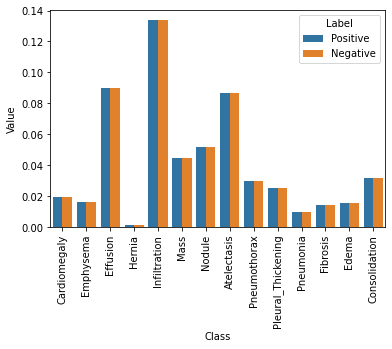

In [25]:
ratios = pd.DataFrame({"Class": classes, "Label": "Positive", "Value": pos_contribution})
ratios = ratios.append([{"Class": classes[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=ratios);